In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
import json
import h5py
import glob
import copy
import pdb
import scipy.stats

import importlib
import util_neurophysiology
importlib.reload(util_neurophysiology)

import pitchnet_evaluate_best

sys.path.append('/packages/tfutil')
import functions_graph_assembly as fga

sys.path.append('assets_psychophysics')
import util_figures_psychophysics

sys.path.append('/om4/group/mcdermott/user/msaddler/pitchnet_dataset/pitchnetDataset/pitchnetDataset')
import dataset_util

sys.path.append('/packages/msutil')
import util_figures
import util_misc
import util_stimuli

import importlib
%matplotlib inline
import matplotlib.pyplot as plt

import IPython.display as ipd


In [2]:
master_list = [
    ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/', 'Speech + music'),
    
#     ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0191_seed*/', 'Speech + music (arch_0191)'),
#     ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0302_seed*/', 'Speech + music (arch_0302)'),
    
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/', 'Speech + music (natural)'),
#     ('/saved_models/models_sr20000/arch_0302/PNDv08PYSmatched12_TLASmatched12_snr_neg10pos10_phase3_AN_BW10eN1_IHC3000Hz_classification*/', 'Synthetic tones (matched)'),
#     ('/saved_models/models_sr20000/arch_0302/PNDv08PYSnegated12_TLASmatched12_snr_neg10pos10_phase3_AN_BW10eN1_IHC3000Hz_classification*/', 'Synthetic tones (anti-matched)'),
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification*/', 'Speech + Music (highpass)'),

#     ('/saved_models/models_sr20000/arch_0302/PND_synthetic_noise_UMNm_snr_neg10pos10_phase0_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification*/', 'Trained on highpass synth. tones'),

#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification0/', 'Trained on speech and music'),

#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/', 'Speech + Music (natural)'),
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_filter_signalBPv00_AN_BW10eN1_IHC3000Hz_classification*/', 'Speech + Music (bandpass)'),
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification*/', 'Speech + Music (highpass)'),
#     ('/saved_models/models_sr20000/arch_0302/PND_synthetic_noise_UMNm_snr_neg10pos10_phase0_filter_signalBPv00_AN_BW10eN1_IHC3000Hz_classification*/', 'Synthetic tones (bandpass)'),
#     ('/saved_models/models_sr20000/arch_0302/PND_synthetic_noise_UMNm_snr_neg10pos10_phase0_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification*/', 'Synthetic tones (highpass)'),

#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_pos10pos30_AN_BW10eN1_IHC3000Hz_classification*/', 'Speech + Music (low noise)'),
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_posInf_AN_BW10eN1_IHC3000Hz_classification*/', 'Speech + Music (no noise)'),
]

# results_basename = 'NEUROPHYSIOLOGY_v01_bernox2005_activations_tuning_low_harm_f0.hdf5'
results_basename = 'NEUROPHYSIOLOGY_v02_bernox2005_activations_tuning_low_harm_f0.hdf5'
# results_basename = 'NEUROPHYSIOLOGY_v02_inharmonic_bernox2005_activations_tuning_low_harm_f0.hdf5'


model_keys = []
results_dicts = {}
for model_dir_regex, model_key in master_list:
    results_dicts[model_key] = []
    model_keys.append(model_key)
    results_fn_regex = os.path.join(model_dir_regex, results_basename)
    for results_fn in sorted(glob.glob(results_fn_regex)):
        with h5py.File(results_fn, 'r') as f:
            key_list = [
#                 'relu_0',
#                 'relu_1',
#                 'relu_2',
#                 'relu_3',
#                 'relu_4',
#                 'relu_fc_intermediate',
                'fc_top',
                'fc_top_softmax',
            ]
            results_dict = {
                'f0_bins': f['f0_bins'][:],
                'f0_label': f['f0_label'][:],
                'low_harm': f['low_harm'][:],
                'octave_bins': f['octave_bins'][:],
            }
            for k in key_list:
                x = f[k][:]
                unit_max_values = x.max(axis=(1, 2), keepdims=True)
                nzidx = np.squeeze(unit_max_values > 0)
                x[nzidx] = x[nzidx] / unit_max_values[nzidx]

                results_dict[k + '_f0_label'] = np.mean(np.mean(x, axis=1), axis=0)

                idx_best_f0 = np.argmax(np.mean(x, axis=1), axis=1)
                x_low_harm_tuning_at_best_f0 = np.zeros([x.shape[0], x.shape[1]], dtype=x.dtype)
                for idx_unit, idx_f0 in enumerate(idx_best_f0):
                    x_low_harm_tuning_at_best_f0[idx_unit, :] = x[idx_unit, :, idx_f0]
                results_dict[k + '_low_harm'] = np.mean(x_low_harm_tuning_at_best_f0, axis=0)
                
#                 results_dict[k + '_f0_label'] = np.mean(f[k + '_population_mean'][:], axis=0)
#                 results_dict[k + '_low_harm'] = np.mean(f[k + '_population_mean'][:], axis=1)
#                 print(k + '_f0_label', results_dict[k + '_f0_label'].shape)
#                 print(k + '_low_harm', results_dict[k + '_low_harm'].shape)
                
                octave_tuning = f[k + '_octave_tuning'][:]
                octave_tuning_count = f[k + '_octave_tuning_count'][:]
                unit_max_values = octave_tuning.max(axis=1, keepdims=True)
                nzidx = np.squeeze(unit_max_values > 0)
                octave_tuning[nzidx] = octave_tuning[nzidx] / unit_max_values[nzidx]
                IDX = np.arange(0, octave_tuning.shape[0], 1, dtype=int)
                
                n_subsample = 3168
                np.random.seed(858)
                np.random.shuffle(IDX)
                subsampled_octave_tuning = octave_tuning[IDX[:n_subsample], :]
                subsampled_octave_tuning_count = octave_tuning_count[IDX[:n_subsample], :]
                                
                tmp = np.sum(subsampled_octave_tuning, axis=0)
                tmp_count = np.sum(subsampled_octave_tuning_count, axis=0)
                tmp[tmp_count > 0] = tmp[tmp_count > 0] / tmp_count[tmp_count > 0]
                results_dict[k + '_octave_tuning'] = tmp
                
            results_dicts[model_key].append(results_dict)
        
        print(model_key, results_fn)


Speech + music /saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0083/NEUROPHYSIOLOGY_v02_bernox2005_activations_tuning_low_harm_f0.hdf5
Speech + music /saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0154/NEUROPHYSIOLOGY_v02_bernox2005_activations_tuning_low_harm_f0.hdf5
Speech + music /saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0190/NEUROPHYSIOLOGY_v02_bernox2005_activations_tuning_low_harm_f0.hdf5
Speech + music /saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0191/NEUROPHYSIOLOGY_v02_bernox2005_activations_tuning_low_harm_f0.hdf5
Speech + music /saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0286/NEUROPHYSIOLOGY_v02_bernox2005_activations_tuning_low_harm_f0.hdf5
Speech + music /saved_models/arch_search_v02_topN/sr200

In [ ]:
importlib.reload(util_neurophysiology)

list_key_layer = [
    'relu_0',
    'relu_1',
    'relu_2',
    'relu_3',
    'relu_4',
    'relu_fc_intermediate',
    'fc_top',
    'fc_top_softmax',
]

ncols = len(list_key_layer)
nrows = 1
gridspec_kw = {
    'wspace': 0.15,
}
fig, ax_arr = plt.subplots(nrows=nrows,
                           ncols=ncols,
                           figsize=(2.2*ncols, 2*nrows),
                           gridspec_kw=gridspec_kw)

for idx_layer, key_layer in enumerate(list_key_layer):
    results_dict_input = results_dicts[model_keys[0]]
    kwargs_plot_update = {'color': 'k', 'label': None}
    str_title = key_layer
    util_neurophysiology.make_octave_tuning_plot(ax_arr[idx_layer],
                                                 results_dict_input,
                                                 key_resp_list=key_layer,
                                                 kwargs_plot_update=kwargs_plot_update,
                                                 xlimits=[-1.2, 1.2],
                                                 ylimits=[0, 1.1],
                                                 str_title=str_title,
                                                 fontsize_title=16,
                                                 fontweight_title='bold',
                                                 yticks=np.arange(0, 1.01, 0.2),
                                                 yticks_minor=np.arange(0, 1.01, 0.2),
                                                 xticks=[-1, 0, 1],
                                                 xticklabels=['-1', '0', '+1'],
                                                 xticks_minor=np.arange(-1.2, 1.21, 0.2))
    if idx_layer > 0:
        ax_arr[idx_layer].set_ylabel(None)
        ax_arr[idx_layer].set_yticks([])
    
    if not idx_layer == 2:
        ax_arr[idx_layer].set_xlabel(None)

plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_09_26_pitchnet_paper_figures_v03/'
# save_fn = os.path.join(save_dir, 'neurophysiology_bernox2005_octave_tuning_arch0191_natural_speech_music.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0)
# print(save_fn)


No handles with labels found to put in legend.


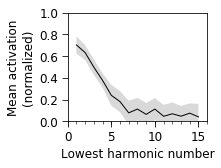

No handles with labels found to put in legend.


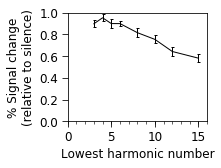

No handles with labels found to put in legend.


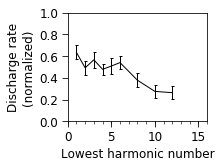

In [4]:
importlib.reload(util_neurophysiology)
color_list = util_figures.get_color_list(6, cmap_name='gist_heat') # CMAP FOR FILTERING SOUNDS
color_list = [color_list[idx] for idx in [0, 2, 4]]
color_list = ['k', color_list[-1]]

figsize = (2.5, 2)
xlimits=[0, 16]
xticks=np.arange(0, 17, 5)
xticks_minor=np.arange(0, 17, 1)

SUPER_DATA_DICT = {}
label_list = [
    'natural_speech_music',
    'anti_matched_synthetic'
]
for cidx, model_key in enumerate(model_keys):
    fig, ax = plt.subplots(nrows=1,
                           ncols=1,
                           figsize=figsize)
    results_dict_input = results_dicts[model_key]
    kwargs_plot_update = {
        'color': color_list[cidx],
        'label': None,
    }
    ax, DATA = util_neurophysiology.make_low_harm_tuning_plot(
        ax,
        results_dict_input,
        key_resp_list=['fc_top'],
        kwargs_plot_update=kwargs_plot_update,
        kwargs_legend_update={'fontsize': 11},
        xlimits=xlimits,
        xticks=xticks,
        xticks_minor=xticks_minor,
        limit_dim0=[1, 30],
    )
    plt.show()
    
    MODEL_KEY = label_list[cidx] + '-bernox2005'
    if MODEL_KEY in SUPER_DATA_DICT:
        SUPER_DATA_DICT[MODEL_KEY] = util_misc.recursive_dict_merge(SUPER_DATA_DICT[MODEL_KEY], DATA)
    else:
        SUPER_DATA_DICT[MODEL_KEY] = DATA

#     save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2021_05_07_pitchnet_paper_figures_v04/'
#     save_fn = os.path.join(save_dir, 'neurophysiology_bernox2005_low_harm_tuning_arch_search_v02_top10_{}.pdf'.format(label_list[cidx]))
#     fig.savefig(save_fn, bbox_inches='tight', pad_inches=0)
#     print(save_fn)



fig, ax = plt.subplots(nrows=1,
                       ncols=1,
                       figsize=figsize)
ax, DATA = util_neurophysiology.make_low_harm_tuning_plot(
    ax,
    util_neurophysiology.get_results_dict_norman_haignere_2013(),
    xlimits=xlimits,
    xticks=xticks,
    xticks_minor=xticks_minor,
    str_ylabel='% Signal change\n(relative to silence)',
    kwargs_legend_update={'loc': 'lower right', 'handlelength': 0},
    limit_dim0=[1, 30],
)
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2021_05_07_pitchnet_paper_figures_v04/'
# save_fn = os.path.join(save_dir, 'neurophysiology_bernox2005_low_harm_tuning_normanhaignere2013.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0)
# print(save_fn)



fig, ax = plt.subplots(nrows=1,
                       ncols=1,
                       figsize=figsize)
ax, DATA = util_neurophysiology.make_low_harm_tuning_plot(
    ax,
    util_neurophysiology.get_results_dict_bendor_and_wang_2005(),
    xlimits=xlimits,
    xticks=xticks,
    xticks_minor=xticks_minor,
    str_ylabel='Discharge rate\n(normalized)',
    limit_dim0=[1, 30],
)
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2021_05_07_pitchnet_paper_figures_v04/'
# save_fn = os.path.join(save_dir, 'neurophysiology_bernox2005_low_harm_tuning_bendorwang2005.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0)
# print(save_fn)



# for k1 in SUPER_DATA_DICT.keys():
#     print(k1)
#     for k2 in SUPER_DATA_DICT[k1].keys():
#         print('\t', k2, SUPER_DATA_DICT[k1][k2].shape)
# print('<><><> [BEGIN] WRITING SUPER_DATA_DICT TO JSON FILE <><><>')
# with open('tmp.json', 'w') as f:
#     json.dump(SUPER_DATA_DICT, f, sort_keys=True, cls=util_misc.NumpyEncoder)
# print('<><><> [END] WRITING SUPER_DATA_DICT TO JSON FILE <><><>')


In [ ]:
importlib.reload(util_neurophysiology)

# model_dir = '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification0/'
model_dir = '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0191/'
# model_dir = '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0302_seed0/'
# results_basename = 'NEUROPHYSIOLOGY_v01_bernox2005_activations_tuning_low_harm_f0.hdf5'
results_basename = 'NEUROPHYSIOLOGY_v02_bernox2005_activations_tuning_low_harm_f0.hdf5'

fn = os.path.join(model_dir, results_basename)
np.random.seed(858)

# list_unit_idx = sorted([4537, 4605, 6750, 2952, 5802]) # Five selected from 15 randomly drawn with random seed 858
list_unit_idx = [2225, 2914, 3069, 3642, 4605] # Five selected from 45 randomly drawn with random seed 858
nrows=1
ncols=5

list_unit_idx = sorted(list(np.random.randint(0, 4608, [160])))
list_unit_idx = sorted(list(np.random.randint(0, 3168, [160])))
list_unit_idx = np.linspace(0, 699, 160, dtype=int)

nrows=9+11
ncols=5+3

with h5py.File(fn, 'r') as f:
    figsize=(2.2*ncols, 2.0*nrows)
    fontsize_ticks = 10
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)#, constrained_layout=True)
    ax = np.array(ax).reshape([nrows, ncols])
    itr0 = 0
    for r_idx in range(nrows):
        for c_idx in range(ncols):
            kwargs_make_2d_tuning_plot = {
                'str_xlabel': None,
                'str_ylabel': 'F0 (Hz)',
            }
            if r_idx < nrows - 1:
                kwargs_make_2d_tuning_plot['str_xlabel'] = None
                kwargs_make_2d_tuning_plot['xticklabels'] = []
            if c_idx > 0:
                kwargs_make_2d_tuning_plot['str_ylabel'] = None
                kwargs_make_2d_tuning_plot['yticklabels'] = []
            if (c_idx == np.ceil(ncols/2) - 1) and (r_idx == nrows - 1):
                kwargs_make_2d_tuning_plot['str_xlabel'] = 'Lowest harmonic number'
            ax[r_idx, c_idx], IMG = util_neurophysiology.make_2d_tuning_plot(
                ax[r_idx, c_idx],
                f,
                key_act='fc_top',
                unit_idx=list_unit_idx[itr0],
                fontsize_ticks=fontsize_ticks,
                **kwargs_make_2d_tuning_plot)
            itr0 += 1
    
#     cbar = fig.colorbar(IMG,
#                         ax=ax,
#                         aspect=10,
#                         pad=0.02,
#                         orientation='vertical')
#     cbar.set_label('Activation\n(normalized)', fontsize=12, labelpad=6)
#     cbar.ax.tick_params(labelsize=fontsize_ticks, length=fontsize_ticks/4)
    plt.show()


# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_09_26_pitchnet_paper_figures_v03/'
# save_fn = os.path.join(save_dir, 'neurophysiology_bernox2005_unit_tuning_examples_arch0191_natural_speech_music.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0)
# print(save_fn)

# fig.savefig('tmp.pdf', bbox_inches='tight', pad_inches=0)


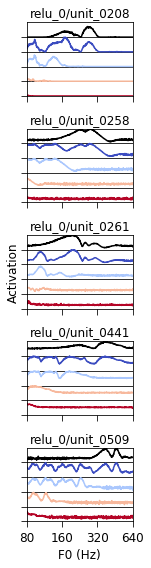

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2021_05_07_pitchnet_paper_figures_v04/neurophysiology_example_units_f0_tuning_relu_0.pdf


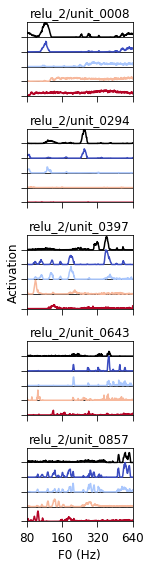

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2021_05_07_pitchnet_paper_figures_v04/neurophysiology_example_units_f0_tuning_relu_2.pdf


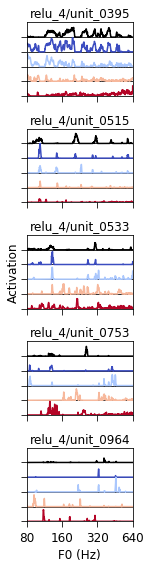

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2021_05_07_pitchnet_paper_figures_v04/neurophysiology_example_units_f0_tuning_relu_4.pdf


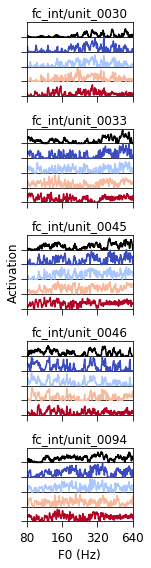

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2021_05_07_pitchnet_paper_figures_v04/neurophysiology_example_units_f0_tuning_relu_fc_intermediate.pdf


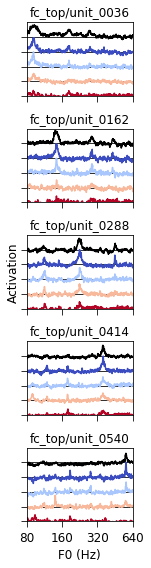

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2021_05_07_pitchnet_paper_figures_v04/neurophysiology_example_units_f0_tuning_fc_top.pdf


In [4]:
importlib.reload(util_neurophysiology)

model_dir = '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0191/'
# results_basename = 'NEUROPHYSIOLOGY_v02_inharmonic_fixed_seed860_bernox2005_activations_tuning_low_harm_f0.hdf5'
results_basename = 'NEUROPHYSIOLOGY_v02_bernox2005_activations_tuning_low_harm_f0.hdf5'

fn = os.path.join(model_dir, results_basename)
with h5py.File(fn, 'r') as f:
    list_layer_name = ['relu_0', 'relu_2', 'relu_4', 'relu_fc_intermediate', 'fc_top']
#     list_layer_name = ['fc_top']
    list_low_harm = [0, 1, 2, 4, 6]
    list_low_harm_color = ['k'] + util_figures.get_color_list(len(list_low_harm) - 1, 'coolwarm')
    
    low_harm = f['low_harm'][:]
    xval = f['f0_label'][:]
    xval_labels = f['f0_bins'][:]
    xtick_indexes = np.linspace(xval[0], xval[-1], 4, dtype=int)
    xticks = [xval[xti] for xti in xtick_indexes]
    xticklabels = ['{:.0f}'.format(xval_labels[xti]) for xti in xtick_indexes]
    
    for itr_layer, layer_name in enumerate(list_layer_name):
        np.random.seed(858 + itr_layer)
    
        nrows = 5
        ncols = 1
        figsize = (2.2*ncols, 1.6*nrows)
        if nrows == 1:
            figsize = (2.4*ncols, 2.4*nrows)
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        ax = np.array(ax).reshape([nrows, ncols])
        
        N = nrows
        if 'fc_top' in layer_name:
            list_unit_idx = np.linspace(0+36, 576-36, N, dtype=int)
        elif 'relu_fc_intermediate' in layer_name:
            list_unit_idx = sorted(list(np.random.randint(0, f[layer_name].shape[0]//2, N)))
        else:
            list_unit_idx = sorted(list(np.random.randint(0, f[layer_name].shape[0]//3, N)))
        if nrows == 1:
            list_unit_idx = [288]#[338]
            assert layer_name == 'fc_top'

        itr0 = 0
        for r_idx in range(nrows):
            c_idx = 0
            tuning_array = f[layer_name][list_unit_idx[itr0]]

            for itr_lh, lh in enumerate(list_low_harm):
                tuning_curve = np.squeeze(tuning_array[low_harm == lh])
                if tuning_curve.max() > 0:
                    tuning_curve = tuning_curve / tuning_array.max()
                if lh == 0:
                    label = 'Pure tone'
                else:
                    label = 'Harm {}-{}'.format(lh, lh + 9 - 1)
                ax[r_idx, c_idx].plot(xval, tuning_curve + len(list_low_harm)-1-itr_lh,
                                      color=list_low_harm_color[itr_lh],
                                      lw=1.5,
                                      label=label)
            kwargs_format_axes = {
                'str_xlabel': 'F0 (Hz)',
                'str_ylabel': 'Activation',
                'str_title': '{}/unit_{:04d}'.format(layer_name, list_unit_idx[itr0]),
                'xticks': xticks,
                'xticklabels': xticklabels,
                'xlimits': [xval[0], xval[-1]],
                'ylimits': [0, len(list_low_harm)],
                'yticks': np.arange(0, len(list_low_harm)),
                'yticklabels': [],
            }
            if 'intermediate' in kwargs_format_axes['str_title']:
                kwargs_format_axes['str_title'] = kwargs_format_axes['str_title'].replace('ermediate', '').replace('relu_', '')
            if r_idx < nrows - 1:
                kwargs_format_axes['str_xlabel'] = None
                kwargs_format_axes['xticklabels'] = []
            if c_idx > 0:
                kwargs_format_axes['str_ylabel'] = None
                kwargs_format_axes['yticklabels'] = []
            if (c_idx == np.ceil(ncols/2) - 1) and (r_idx == nrows - 1):
                kwargs_format_axes['str_xlabel'] = 'F0 (Hz)'
                if 'inharmonic' in results_basename:
                    kwargs_format_axes['str_xlabel'] = 'Nominal F0 (Hz)'
            ax[r_idx, c_idx] = util_figures.format_axes(ax[r_idx, c_idx], **kwargs_format_axes)
            ax[r_idx, c_idx].grid(axis='y', color='k')
#             if (r_idx == 0) and (c_idx == 0):
#                 ax[r_idx, c_idx].legend()

            ax[r_idx, c_idx].set_ylabel('Activation', labelpad=-3)
            if nrows == 5 and r_idx !=2:
                ax[r_idx, c_idx].set_ylabel(None, labelpad=-3)
            itr0 += 1
    
        plt.tight_layout()
        plt.show()

#         save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2021_05_07_pitchnet_paper_figures_v04'
#         save_fn = os.path.join(save_dir, 'neurophysiology_example_units_f0_tuning_{}.pdf'.format(layer_name))
#         pad_inches = 0.1
#         if nrows == 1:
#             pad_inches = 0.05
#             save_fn = save_fn.replace('.pdf', '_unit_{:04d}.pdf'.format(list_unit_idx[0]))
#         if 'inharmonic' in results_basename:
#             save_fn = save_fn.replace('.pdf', '_inharmonic.pdf')
#         print(save_fn)
#         fig.savefig(save_fn, bbox_inches='tight', pad_inches=pad_inches, transparent=True)


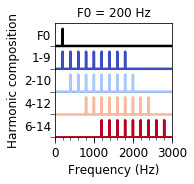

In [7]:
importlib.reload(util_neurophysiology)

list_low_harm = [1, 1, 2, 4, 6]
list_nharm = [1, 9, 9, 9, 9]
list_low_harm_color = ['k'] + util_figures.get_color_list(len(list_low_harm) - 1, 'coolwarm')
    
figsize = (2.1, 2.1)
fontsize_ticks = 10
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

HARMONIC = True
np.random.seed(860)
freq = np.arange(0, 3e3, 1e0)
f0 = 200.0

all_possible_harmonic_numbers = np.arange(1, 15 + 9)
jittered_frequencies = np.zeros_like(all_possible_harmonic_numbers)
while np.min(np.diff(jittered_frequencies)) < 30.0:
    frequencies = 80.0 * all_possible_harmonic_numbers
    fixed_jitter_values = np.random.uniform(
        low=-0.5,
        high=0.5,
        size=frequencies.shape)
    jittered_frequencies = frequencies + 80.0 * fixed_jitter_values


ytick_labels = []
for itr_lh, lh in enumerate(list_low_harm):
    spec = np.zeros_like(freq)
    for h in range(lh, lh + list_nharm[itr_lh]):
        if HARMONIC:
            IDX = np.argmin(np.abs(freq - f0 * h))
        else:
            IDX = np.argmin(np.abs(freq - f0 * h + f0 * fixed_jitter_values[h - 1]))
        spec[IDX] = 0.75
    
    if h > lh:
        label = '{}-{}'.format(lh, h)
    else:
        label = 'F0'
    ytick_labels = [label] + ytick_labels

    ax.plot(freq,
            spec + len(list_low_harm)-1-itr_lh,
            color=list_low_harm_color[itr_lh],
            lw=2.5)
kwargs_format_axes = {
    'str_xlabel': 'Frequency (Hz)',
    'str_ylabel': 'Harmonic composition',
    'str_title': 'F0 = {:.0f} Hz'.format(f0),
    'xticks': np.arange(0, 3e3+1, 1e3),
    'xticks_minor': np.arange(0, 3e3+1, f0),
    'xticklabels': None,
    'xlimits': [freq[0], freq[-1]+1],
    'ylimits': [0, len(list_low_harm)],
    'yticks': np.arange(0, len(list_low_harm)) + 0.5,
    'yticks_minor': np.arange(0, len(list_low_harm)),
    'yticklabels': ytick_labels,
    'fontsize_ticks': 12,
    'fontsize_labels': 12,
}
if not HARMONIC:
    kwargs_format_axes['str_title'] = 'Nominal F0 = {:.0f} Hz'.format(f0)

ax = util_figures.format_axes(ax, **kwargs_format_axes)
ax.tick_params(axis='y', which='major', length=0)
ax.tick_params(axis='y', which='minor', length=fontsize_ticks/2)
ax.grid(axis='y', which='minor', color='k')
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2021_05_07_pitchnet_paper_figures_v04'
# save_fn = os.path.join(save_dir, 'neurophysiology_schematic_stimuli_harmonic.pdf')
# if not HARMONIC:
#     save_fn = save_fn.replace('_harmonic', '_inharmonic')
# print(save_fn)
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0.05, transparent=True)


In [8]:
def get_f0_correlations(fn, list_low_harm=None, verbose=True):
    '''
    '''
    with h5py.File(fn, 'r') as f:
        if list_low_harm is None:
            list_low_harm = f['low_harm'][:]
        assert list_low_harm[0] == 0
        results_dict = {
            'config/fn': fn,
            'config/list_low_harm': np.array(list_low_harm[1:]).reshape([-1]),
        }
        for k in util_misc.get_hdf5_dataset_key_list(f):
            if len(f[k].shape) == 3:
                results_dict[k] = []
                _, _, IDX_LH = np.intersect1d(list_low_harm, f['low_harm'], return_indices=True)
                for itr_unit in range(f[k].shape[0]):
                    tuning_array = f[k][itr_unit, IDX_LH]
                    unit_list_correlations = []
                    for itr_lh in range(1, list_low_harm.shape[0]):
                        r, p = scipy.stats.pearsonr(
                            tuning_array[0],
                            tuning_array[itr_lh],
                        )
                        unit_list_correlations.append(r)
                    results_dict[k].append(unit_list_correlations)
                results_dict[k] = np.array(results_dict[k])
                if verbose:
                    print('Processed: {}'.format(k),
                          results_dict[k].shape,
                          np.sum(~np.isfinite(results_dict[k])))
    fn_json_results_dict = fn.replace('.hdf5', '_correlations_results_dict.json')
    assert not fn_json_results_dict == fn
    with open(fn_json_results_dict, 'w') as f:
        json.dump(results_dict, f, cls=util_misc.NumpyEncoder)
    print('[END] wrote: {}'.format(fn_json_results_dict))
    return results_dict


regex_model_dir = '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/'
list_model_dir = glob.glob(regex_model_dir)
list_basename = [
    'NEUROPHYSIOLOGY_v02_bernox2005_activations_tuning_low_harm_f0.hdf5',
    'NEUROPHYSIOLOGY_v02_inharmonic_fixed_seed858_bernox2005_activations_tuning_low_harm_f0.hdf5',
    'NEUROPHYSIOLOGY_v02_inharmonic_fixed_seed859_bernox2005_activations_tuning_low_harm_f0.hdf5',
    'NEUROPHYSIOLOGY_v02_inharmonic_fixed_seed860_bernox2005_activations_tuning_low_harm_f0.hdf5',
    'NEUROPHYSIOLOGY_v02_inharmonic_fixed_seed861_bernox2005_activations_tuning_low_harm_f0.hdf5',
    'NEUROPHYSIOLOGY_v02_inharmonic_fixed_seed862_bernox2005_activations_tuning_low_harm_f0.hdf5',
]
list_fn = []
for model_dir in list_model_dir:
    for basename in list_basename:
        list_fn.append(os.path.join(model_dir, basename))
# list_results_dict = []
# for fn in list_fn:
#     print(fn)
#     list_results_dict.append(get_f0_correlations(fn, list_low_harm=None, verbose=False))


In [9]:
regex_basename_results_dict = '*_correlations_results_dict.json'

list_low_harm = [1, 2, 4, 6]
super_results_dict = {}

for model_dir in list_model_dir:
    key_model = os.path.basename(model_dir[:-1])
    super_results_dict[key_model] = {}
    list_fn_results_dict = glob.glob(os.path.join(model_dir, regex_basename_results_dict))
    for fn in list_fn_results_dict:
        if 'inharmonic' in fn:
            key_stim = 'inharmonic'
        else:
            key_stim = 'harmonic'
        if key_stim not in super_results_dict[key_model].keys():
            super_results_dict[key_model][key_stim] = {}
        with open(fn, 'r') as f:
            rd = json.load(f)
            _, _, IDX_LH = np.intersect1d(list_low_harm, rd['config/list_low_harm'], return_indices=True)
            for key_layer in rd.keys():
                if 'config' not in key_layer:
                    tmp = np.array(rd[key_layer])[:, IDX_LH]
                    tmp = np.mean(tmp, axis=1)
                    tmp = tmp[np.isfinite(tmp)]
                    tmp = np.mean(tmp, axis=0)
                    if key_layer not in super_results_dict[key_model][key_stim].keys():
                        super_results_dict[key_model][key_stim][key_layer] = []
                    super_results_dict[key_model][key_stim][key_layer].append(tmp)
    print(key_model)

# print(json.dumps(super_results_dict, indent=4, sort_keys=True))


arch_0083
arch_0154
arch_0190
arch_0191
arch_0286
arch_0288
arch_0302
arch_0335
arch_0338
arch_0346


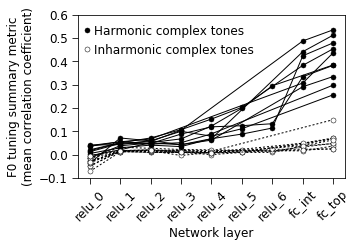

In [10]:
fig, ax = plt.subplots(figsize=(4.8, 3))

list_layer_names = [
    'relu_0',
    'relu_1',
    'relu_2',
    'relu_3',
    'relu_4',
    'relu_5',
    'relu_6',
#     'relu_7',
#     'relu_8',
    'relu_fc_intermediate',
    'fc_top',
#     'fc_top_softmax',
]

list_plot_dict = []
for _, rd in super_results_dict.items():
    plot_dict = {
        'x': [],
        'y_harmonic': [],
        'y_inharmonic': [],
    }
    for x, k in enumerate(list_layer_names):
        if k in rd['harmonic'].keys():
            plot_dict['x'].append(x)
            plot_dict['y_harmonic'].append(np.mean(rd['harmonic'][k]))
            plot_dict['y_inharmonic'].append(np.mean(rd['inharmonic'][k]))
    for key in plot_dict.keys():
        plot_dict[key] = np.array(plot_dict[key])
    list_plot_dict.append(plot_dict)

kwargs_plot_harmonic = {
    'color': 'k',
    'mfc': 'k',
    'marker': 'o',
    'ms': 5,
    'mew': 0.5,
    'lw': 1.0,
    'ls': '-',
    'label': 'Harmonic complex tones',
}
kwargs_plot_inharmonic = copy.deepcopy(kwargs_plot_harmonic)
kwargs_plot_inharmonic['label'] = kwargs_plot_harmonic['label'].replace('Harm', 'Inharm')
kwargs_plot_inharmonic['mfc'] = 'w'
kwargs_plot_inharmonic['ls'] = '--'
kwargs_plot_inharmonic['dashes'] = (2, 2)

for itr_pd, pd in enumerate(list_plot_dict):
    if itr_pd > 0:
        kwargs_plot_harmonic['label'] = None
        kwargs_plot_inharmonic['label'] = None
    ax.plot(pd['x'], pd['y_harmonic'], **kwargs_plot_harmonic)
    ax.plot(pd['x'], pd['y_inharmonic'], **kwargs_plot_inharmonic)
#     ax.plot(pd['x'], pd['y_harmonic'] - pd['y_inharmonic'], 'k.-')

xticks = np.arange(0, len(list_layer_names))
xticklabels = list_layer_names
xticklabels[xticklabels.index('relu_fc_intermediate')] = 'fc_int'
kwargs_format_axes = {
    'str_xlabel': 'Network layer',
    'str_ylabel': 'F0 tuning summary metric\n(mean correlation coefficient)',
    'xlimits': None,
    'xticks': xticks,
    'xticklabels': xticklabels,
    'ylimits': [-0.1, 0.6],
    'yticks': np.arange(-0.1, 0.61, 0.1),
}
ax = util_figures.format_axes(ax, **kwargs_format_axes)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
legend_plot_kwargs = {
    'loc':'best',
    'bbox_to_anchor': (0.0, 0.6, 1.0, 0.4),
    'borderpad': 0.6,
    'borderaxespad': 0.2,
    'handletextpad': 0.6,
    'frameon': False,
    'handlelength': 0.0,
    'markerscale': 1.0,
    'fontsize': 12,
}
leg = ax.legend(**legend_plot_kwargs)
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2021_05_07_pitchnet_paper_figures_v04'
# save_fn = os.path.join(save_dir, 'neurophysiology_layerwise_f0_tuning_consistency_lharm1246.pdf')
# print(save_fn)
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0)


In [2]:
importlib.reload(util_neurophysiology)

fn_stim = '/om/user/msaddler/data_pitchnet/bernox2005/neurophysiology_v02_EqualAmpTEN_lharm01to15_phase0_f0min080_f0max640/stim.hdf5'
regex_nerveram = '/om/user/msaddler/data_pitchnet/bernox2005/neurophysiology_v02_EqualAmpTEN_lharm01to15_phase0_f0min080_f0max640/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/*hdf5'
list_fn_nervegram = sorted(glob.glob(regex_nerveram))

list_low_harm = [0, 1, 2, 4, 6]
map_index_to_fn_nervegram = []
map_fn_to_hdf5_file = {}
for fn in list_fn_nervegram:
    tmp = os.path.basename(fn).replace('bez2018meanrates_', '').replace('.hdf5', '')
    idx_start, idx_end = [int(_) for _ in tmp.split('-')]
    for idx in range(idx_start, idx_end):
        map_index_to_fn_nervegram.insert(idx, (fn, idx - idx_start))
    map_fn_to_hdf5_file[fn] = h5py.File(fn, 'r')

with h5py.File(fn_stim, 'r') as f:
    list_list_idx = []
    for low_harm in list_low_harm:
        if low_harm == 0:
            IDX = np.logical_and(
                f['min_audible_harm'][:] == 1,
                f['max_audible_harm'][:] == 1)
        else:
            IDX = np.logical_and(
                f['min_audible_harm'][:] == low_harm,
                f['max_audible_harm'][:] == low_harm + 8)
        list_idx = np.arange(0, IDX.shape[0], dtype=int)[IDX]
        list_list_idx.append(list_idx)


def get_nervegram_val(f, idx):
    '''
    '''
    if isinstance(f, str):
        f = map_fn_to_hdf5_file[f]
    val = np.mean(f['nervegram_meanrates'][idx, 16, :])
    f0 = f['f0'][idx]
    return f0, val


list_list_f0 = []
list_list_activation = []
for itr_lh, list_idx in enumerate(list_list_idx):
    list_f0 = []
    list_activation = []
    for itr0 in list_idx:
        f0, val = get_nervegram_val(*map_index_to_fn_nervegram[itr0])
        list_f0.append(f0)
        list_activation.append(val)
    list_list_f0.append(list_f0)
    list_list_activation.append(list_activation)
    print(list_low_harm[itr_lh])

for fn in map_fn_to_hdf5_file.keys():
    map_fn_to_hdf5_file[fn].close()


0
1
2
4
6


In [ ]:
with h5py.File(fn, 'r') as f:
    cf_list = f['cf_list'][0]
for itr_cf, cf in enumerate(cf_list):
    if cf < 640:
        print(itr_cf, cf)


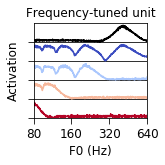

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2021_05_07_pitchnet_paper_figures_v04/neurophysiology_schematic_unit_frequency_tuned_unit_cf414Hz.pdf


In [10]:
importlib.reload(util_neurophysiology)

sys.path.append('/om4/group/mcdermott/user/msaddler/pitchnet_dataset/pitchnetDataset/pitchnetDataset')
import dataset_util

# str_title = 'F0-tuned unit'
str_title = 'Frequency-tuned unit'

kwargs_f0_bins = {}
f0_bins = dataset_util.get_f0_bins(**kwargs_f0_bins)

array_f0_label = dataset_util.f0_to_label(np.array(list_list_f0, dtype=np.float32), f0_bins)
list_f0_label = array_f0_label[0]
array_activation = np.array(list_list_activation)

list_low_harm = [0, 1, 2, 4, 6]
list_low_harm_color = ['k'] + util_figures.get_color_list(len(list_low_harm) - 1, 'coolwarm')

xval = np.unique(list_f0_label)
xval_labels = f0_bins
xtick_indexes = np.linspace(xval[0], xval[-1], 4, dtype=int)
xticks = [xval[xti] for xti in xtick_indexes]
xticklabels = ['{:.0f}'.format(xval_labels[xti]) for xti in xtick_indexes]
xticklabels

nrows = 1
ncols = 1
figsize = (2.1*ncols, 1.6*nrows)
if nrows == 1:
    figsize = (2.4*ncols, 2.4*nrows)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
ax = np.array(ax).reshape([nrows, ncols])

for r_idx in range(nrows):
    c_idx = 0

    for itr_lh, lh in enumerate(list_low_harm):
        tuning_curve = np.zeros_like(xval)
        for itr_x, x in enumerate(xval):
            if 'f0' in str_title.lower():
                tuning_curve[itr_x] = np.mean(array_activation[0, list_f0_label == x])
            else:
                tuning_curve[itr_x] = np.mean(array_activation[itr_lh, list_f0_label == x])
        tuning_curve = tuning_curve - tuning_curve.min()
        tuning_curve = 0.85 * tuning_curve / tuning_curve.max()
        if lh == 0:
            label = 'Pure tone'
        else:
            label = 'Harm {}-{}'.format(lh, lh + 9 - 1)
        ax[r_idx, c_idx].plot(xval, tuning_curve + len(list_low_harm)-1-itr_lh,
                              color=list_low_harm_color[itr_lh],
                              lw=1.5,
                              label=label)
        
        kwargs_format_axes = {
            'str_xlabel': 'F0 (Hz)',
            'str_ylabel': 'Activation',
            'str_title': str_title,
            'xticks': xticks,
            'xticklabels': xticklabels,
            'xlimits': [xval[0], xval[-1]],
            'ylimits': [0, len(list_low_harm)],
            'yticks': np.arange(0, len(list_low_harm)),
            'yticklabels': [],
        }

        ax[r_idx, c_idx] = util_figures.format_axes(ax[r_idx, c_idx], **kwargs_format_axes)
        ax[r_idx, c_idx].grid(axis='y', color='k')
#         if (r_idx == 0) and (c_idx == 0):
#             ax[r_idx, c_idx].legend()
        itr0 += 1

plt.tight_layout()
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2021_05_07_pitchnet_paper_figures_v04'
# save_fn = os.path.join(save_dir, 'neurophysiology_schematic_unit_{}_cf414Hz.pdf'.format(str_title.lower().replace(' ', '_').replace('-', '_')))
# pad_inches = 0.05
# print(save_fn)
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=pad_inches, transparent=True)
